## Topic Modeling: alpha-testing various methods

- by Matt Jackson
- Feb. 13, 2024

- Note: This is a document intended to demonstrate methods I tested for exploratory data analysis, and does not contain finalized work product for the team project.

Library imports

In [1]:
import pandas as pd 
import numpy as np
import re
import os
import nltk
nltk.download("stopwords") #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer #https://www.geeksforgeeks.org/snowball-stemmer-nlp/
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()
stops = list(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text cleaning and preprocessing

Much of this functionality was later incorporated into `text_parser.py`.

In [2]:
add_more_stops = False
findings_are_stops = False
if add_more_stops:
    # consider customizing the list of stopwords more to remove very common words
    custom_stops = ["officer", "chicago", "il", "illinois", "copa", "th", "",
                    "incident", "ms", "mrs", "mr", "ipra"]
    stops += custom_stops
if findings_are_stops:
    finding_stops = ["sustained", "not sustained", "unfounded", "exonerated"]
    stops += finding_stops

HEADERS = re.compile(
    r"independent police review authority|"
    r"civilian office of police accountability|"
    r"log#?\d+|"
    r"summary report of investigation|"
    r"executive summary|"
    r"involved parties|"
    r"allegations|"
    r"alleged that|"
    r"applicable rules and laws|"
    r"conclusion|"
    r"digital evidence|"
    r"documentary evidence|"
    r"legal standard|"
    r"preponderance of (the |)evidence|"
    r"more likely than not|"
    r"clear and convincing( evidence|)|"
    r"recommended (discipline|penalty)"
    r"violation noted"
    r"xxx*|bbb+|" #i think this is how some redactions get turned into .txt
    r"\_+"
    , re.IGNORECASE
)

In [3]:
def preprocess(data: str, 
               remove_stops=True, 
               stem=True,
               lemmatize=True, 
               return_as_list=True):
    """Pre-process the contents of a .txt file."""
    data = re.sub('\n', ' ', data) 
    data = data.lower()
    data = re.sub(r'[^\w\s]|/|\_', '', data)
    data = re.sub(r'\d+', '', data) #remove all numbers
    data = re.sub(HEADERS, '', data)
    
    data = data.split(" ")
    if remove_stops:
        data = [w for w in data if w not in stops]
        if stem:
            data = [stemmer.stem(w) for w in data]
        elif lemmatize: #TODO: try both and see what happens
            data = [lemmatizer.lemmatize(w) for w in data]
    if return_as_list:
        return [w for w in data if w != ""]
    else:
        return ' '.join(data)
    


In [4]:
EXAMPLE_FILE = os.path.join(os.getcwd(), "text_files/1092650.txt")
with open(EXAMPLE_FILE, 'r') as f:
    data = ' '.join(f.readlines())
raw_data = preprocess(data, stem=False, lemmatize=False)
stemmed_data = preprocess(data, stem=True) #these should probably not be exactly the same
lemmatized_data = preprocess(data, lemmatize=True)

print(raw_data)
print(stemmed_data)
print(lemmatized_data)

['log', 'datetimelocation', 'incident', 'datetime', 'copa', 'notification', 'involved', 'officer', 'involved', 'individual', 'case', 'type', 'officer', 'officer', 'burdett', 'griffin', 'iii', 'february', 'unknown', 'w', 'harrison', 'street', 'chicago', 'il', 'february', 'pm', 'griffin', 'iii', 'burdett', 'star', 'employee', 'id', 'date', 'appointment', 'may', 'police', 'officer', 'unit', 'assignment', 'dob', 'male', 'black', 'female', 'black', 'domestic', 'harassmentintimidation', 'allegation', 'february', 'unknown', 'time', 'near', 'w', 'harrison', 'street', 'chicago', 'il', 'officer', 'burdett', 'griffin', 'iii', 'harassed', 'calling', 'multiple', 'times', 'february', 'unknown', 'time', 'near', 'w', 'harrison', 'street', 'chicago', 'il', 'officer', 'burdett', 'griffin', 'iii', 'intimidated', 'stating', 'words', 'effect', 'called', 'copa', 'deserve', 'beat', 'february', 'unknown', 'time', 'near', 'w', 'harrison', 'street', 'chicago', 'il', 'officer', 'burdett', 'griffin', 'iii', 'dire

Import all text files and create a corpus of pre-processed strings of text, one per file

In [5]:
def get_full_corpus(
        preprocess_input=True,
        stem_input=False,
        lemmatize_input=False,
        print_progress=False):
    """
    Extract text from every .txt file in a folder.
    Returns (list): a corpus, with each document's text as a single long string
    """
    DIR = "../../text_files"
    #DIR = os.path.join(os.getcwd(), "text_files")
    print(DIR)

    corpus = []

    for i, filename in enumerate(os.listdir(DIR)):
        if print_progress and i % 100 == 0:
            print(f"Extracting text from file {i}...")
        if filename.endswith(".txt"):
            filepath = os.path.join(DIR, filename)
            with open(filepath, 'r') as f:
                data = ''.join(f.readlines())
            data = re.sub('\n', ' ', data)
            if preprocess_input:
                data = preprocess(data, 
                                  stem=stem_input,
                                  lemmatize=lemmatize_input,
                                  return_as_list=False)
            corpus.append(data)

    if print_progress:
        print("Corpus text extraction complete")
    return corpus

#Hyperparameter to tune: whether corpus is stemmed, lemmatized, both, or neither
raw_corpus = get_full_corpus()
print("Raw corpus complete")
stemmed_corpus = get_full_corpus(stem_input=True)
print("Stemmed corpus complete")
lemmatized_corups = get_full_corpus(lemmatize_input=True)
print("Lemmatized corpus complete")

# Without pre-processing step, runs in about 2 seconds. With pre-processing step,
# runs in about 1 minute


/Users/mbjackson/Documents/Advanced ML /NLP-Police-Complaints/text_files
Raw corpus complete
/Users/mbjackson/Documents/Advanced ML /NLP-Police-Complaints/text_files


In [ ]:
raw_corpus

### Count and Vectorize

The scikit-learn CountVectorizer allows us to quickly count word frequency within documents and then store that information as a matrix, with labeled columns for each word. It also has a TfidfVectorizer, which quickly computes tf-idf (see PA3, CAPP 121).

Words and phrases that will be redundant across almost every report should be removed prior to topic modeling, since a word in every or almost every document is unhelpful for distinguishing which report contains which topic. The Chile paper set thresholds for minimum and max word frequency manually (I think at 15 and 400), which we should also be able to do, by inspection if necessary, and by assessing results of grid search if not.

In [29]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

cvectorizer = CountVectorizer(stop_words=stops)
X = cvectorizer.fit_transform(corpus)
feature_names = cvectorizer.get_feature_names_out()

vectorizer_raw = TfidfVectorizer(stop_words=stops)
Y = vectorizer_raw.fit_transform(corpus)
feature_names = vectorizer_raw.get_feature_names_out()

vectorizer_clean = TfidfVectorizer(stop_words=stops, min_df=1, max_df=0.95)
Y2 = vectorizer_clean.fit_transform(corpus)
feature_names2 = vectorizer_clean.get_feature_names_out()

print(f"Total number of non-stopwords: {len(feature_names)}")


Total number of non-stopwords: 38016


Proto-grid search different possibilities to see how many words get excluded for different settings.

In [27]:
DF_MINS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 40]
MAX_DFS = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

for df_min in DF_MINS:
    for df_max in MAX_DFS:
        vectorizer_grid = TfidfVectorizer(stop_words=stops, min_df=df_min, max_df=df_max)
        Yg = vectorizer_grid.fit_transform(corpus)
        fn_grid = vectorizer_grid.get_feature_names_out()
        w_tot = len(fn_grid)
        print(f"Total words if min_df={df_min} and max_df={df_max}: {w_tot}")

Total words if min_df=1 and max_df=0.5: 37768
Total words if min_df=1 and max_df=0.6: 37856
Total words if min_df=1 and max_df=0.7: 37922
Total words if min_df=1 and max_df=0.8: 37975
Total words if min_df=1 and max_df=0.9: 38000
Total words if min_df=1 and max_df=0.95: 38008
Total words if min_df=1 and max_df=0.99: 38016
Total words if min_df=2 and max_df=0.5: 17990
Total words if min_df=2 and max_df=0.6: 18078
Total words if min_df=2 and max_df=0.7: 18144
Total words if min_df=2 and max_df=0.8: 18197
Total words if min_df=2 and max_df=0.9: 18222
Total words if min_df=2 and max_df=0.95: 18230
Total words if min_df=2 and max_df=0.99: 18238
Total words if min_df=3 and max_df=0.5: 13776
Total words if min_df=3 and max_df=0.6: 13864
Total words if min_df=3 and max_df=0.7: 13930
Total words if min_df=3 and max_df=0.8: 13983
Total words if min_df=3 and max_df=0.9: 14008
Total words if min_df=3 and max_df=0.95: 14016
Total words if min_df=3 and max_df=0.99: 14024
Total words if min_df=4 and 

Looks like the vast majority of the feature selection is in min_df argument

TODO: some charts to visualize this dropoff of words with rise of min_df. Also TODO: see how much different vocab sizes affect training speed for models.

Also, see how much of the "the topics are just officers' names" issue fades as min_df is raised


### Model-agnostic setup

In [7]:
#IMPORTANT: whatever the settings are, tfidf and tf must use the same ones!
# Note: Will need to create separate vectorizers for different modifications to corpus
tfidf_vectorizer = TfidfVectorizer(stop_words=stops + ["subject"], min_df=2, max_df=0.95)
tfidf = tfidf_vectorizer.fit_transform(stemmed_corpus)
tf_vectorizer = CountVectorizer(stop_words=stops + ["subject"], min_df=2, max_df=0.95)
tf = tf_vectorizer.fit_transform(stemmed_corpus)
#TODO: Consider export of these models to file for better archival

I am doing preliminary tests on these broad classes of model:
- Latent Dirichlet Allocation (LDA)
- Non-Negative Matrix Factorization (NMF)
- K-means Clustering
- Truncated SVD / Latent Semantic Analysis (LSA) K-Means

### Latent Dirichlet Allocation (LDA) proof-of-concept

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from time import time

# This entire script heavily based on and indebted to:
#  Olivier Grisel,  Lars Buitinck, Chyi-Kwei Yau
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

#TODO: Function-wrap entire pipeline for easy setup and execution.

TOPICS_NUMS = [4, 6, 8, 10, 12, 15, 20]

lda = LatentDirichletAllocation(
    n_components=10, #tunable
    max_iter=5, #tunable
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

t0 = time()
print("Beginning fit of LDA model...")
# Best practice is to fit LDA with raw counts, not tf-idf
# https://www.reddit.com/r/MachineLearning/comments/2vk7cy/latent_dirichlet_allocation_vs_tfidf_for_indexing/ 
# https://datascience.stackexchange.com/questions/21950/why-should-we-not-feed-lda-with-tf-idf-input
lda.fit(tf)
print(f"Model fit in {time() - t0} seconds.")

tf_feature_names = tf_vectorizer.get_feature_names_out()

Beginning fit of LDA model...
Model fit in 21.500047206878662 seconds.


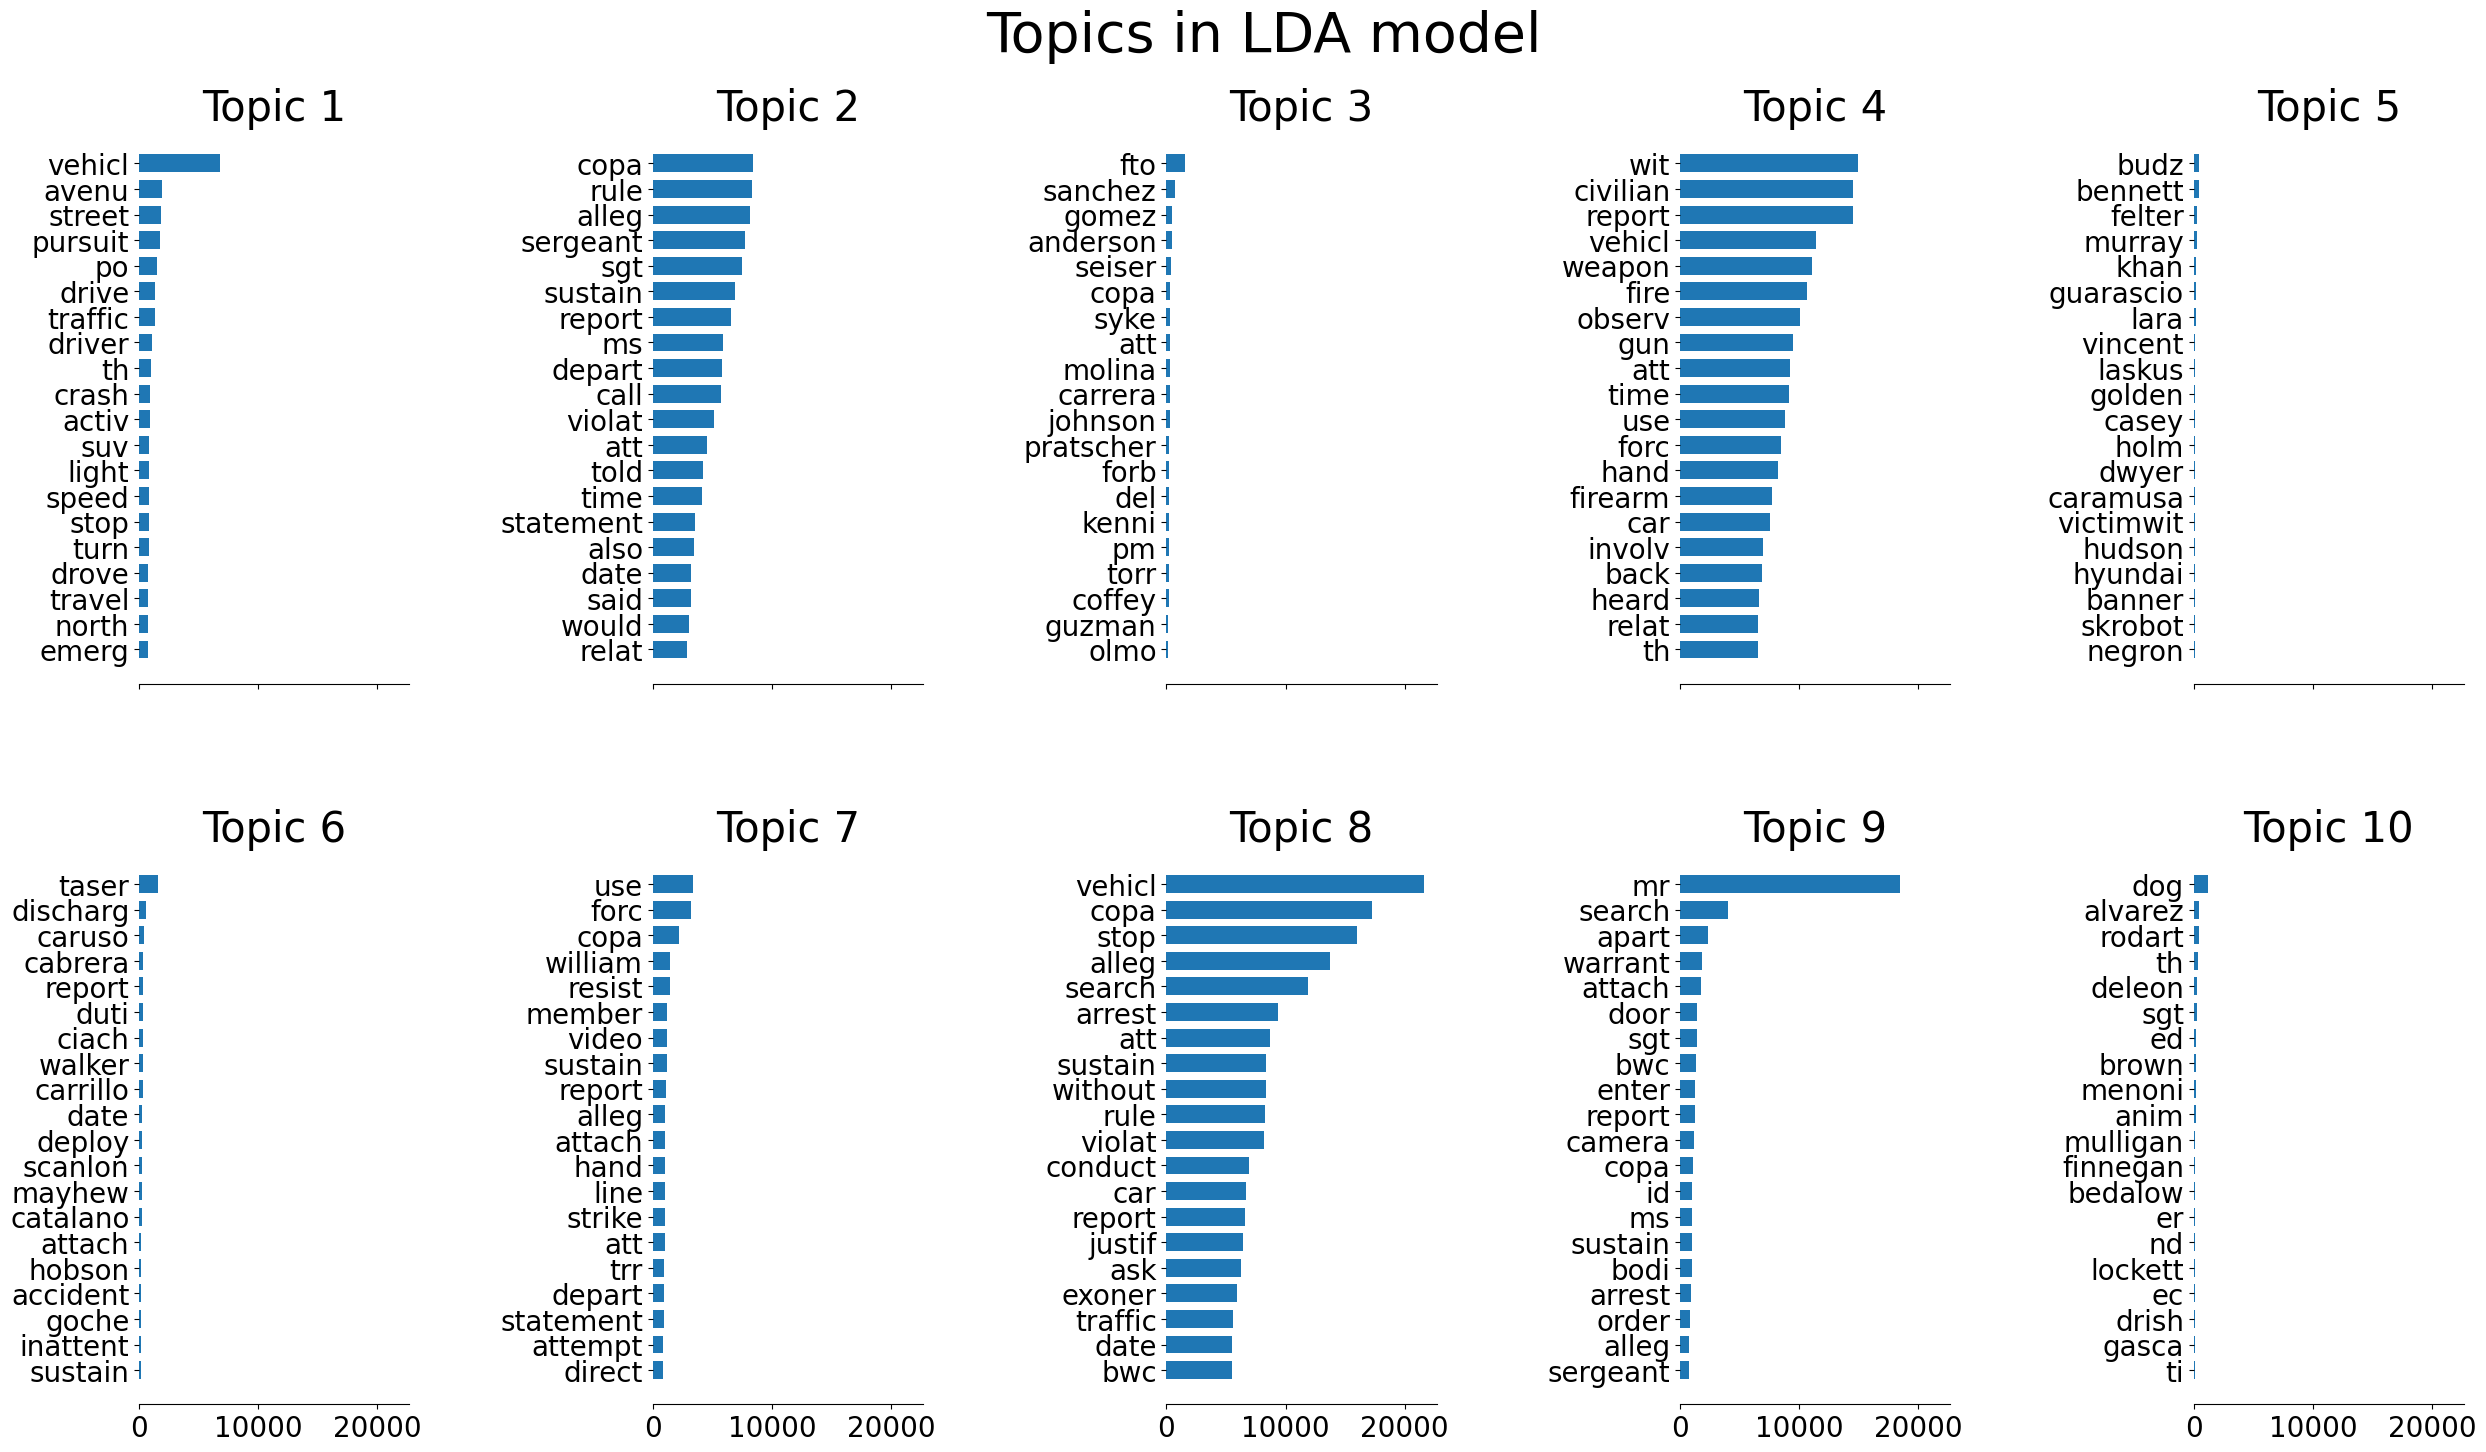

In [13]:
def plot_top_words(model, feature_names, title, n_top_words=20):
    #TODO: determine number of subplots from number of topics plotted
    # Will have empty plots and/or fail if number of topics isn't even
    # there's probably some way for Matplotlib to auto-determine this
    ROWS = 2
    COLUMNS = len(lda.components_) // 2
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        #TODO: make x-axis labels closer to vertical

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tf_feature_names = tf_vectorizer.get_feature_names_out()
#TODO: incorporate more hyperparameters into plot title
#TODO: autosave plot output to file with timestamped title for easy comparison and record-keeping
plot_top_words(lda, tf_feature_names, "Topics in LDA model", n_top_words=20)

#TODO: figure out how to get document labels/weights by topic

### Extract topics by document (LDA)

The `.transform()` method in scikit-learn transforms the LDA model into a matrix where each row represents a document, and each column represents the probability (?) of being in that topic (values across topics sum to 1). There is usually a clear winner, with only one or two substantial follow-ups and most topics close to 0 for most documents.

Possible future steps: A lot of online tutorials suggest that creating this model with the `gensim` library makes these transformations easier. Writing data to .csv could also help with reproducibility, and plotting the relative size and distribution (in terms of number of documents probably given that label) could also be informatiove.

In [22]:
# Source cited: https://stackoverflow.com/questions/45145368/python-scikit-learn-get-documents-per-topic-in-lda

doc_topic = lda.transform(tf)
#doc_topic

for n in range(doc_topic.shape[0]):
    print(f"Document {n}: ", ['{:.2f}'.format(i) for i in doc_topic[n]])
    topic_most_pr = doc_topic[n].argmax() + 1
    print(f"Document {n} top topic: {topic_most_pr}\n")

Document 0:  ['0.00', '0.68', '0.31', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00']
Document 0 top topic: 2

Document 1:  ['0.00', '0.21', '0.00', '0.00', '0.00', '0.00', '0.00', '0.58', '0.00', '0.20']
Document 1 top topic: 8

Document 2:  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']
Document 2 top topic: 8

Document 3:  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.73', '0.27', '0.00']
Document 3 top topic: 8

Document 4:  ['0.00', '0.00', '0.00', '0.15', '0.00', '0.00', '0.08', '0.65', '0.12', '0.00']
Document 4 top topic: 8

Document 5:  ['0.00', '0.00', '0.00', '0.96', '0.04', '0.00', '0.00', '0.00', '0.00', '0.00']
Document 5 top topic: 4

Document 6:  ['0.00', '0.24', '0.00', '0.31', '0.00', '0.00', '0.00', '0.10', '0.35', '0.00']
Document 6 top topic: 9

Document 7:  ['0.00', '0.03', '0.00', '0.00', '0.00', '0.00', '0.51', '0.25', '0.21', '0.00']
Document 7 top topic: 7

Document 8:  ['0.00', '0.00', '0.00', '0.24', '0

### Extract top topic for each word

In [35]:
import numpy as np
word_topic = lda.components_

topic_word = np.array(lda.components_).T

tf_feature_names = tf_vectorizer.get_feature_names_out()

for i, row in enumerate(topic_word):
    print(f"{tf_feature_names[i]}: {[round(j, 1) for j in row]}")
    print(f"{tf_feature_names[i]} top topic: {row.argmax() + 1}, count: {sum(row)}\n")

aa: [0.2, 23.0, 0.1, 9.1, 0.1, 0.1, 1.9, 76.1, 0.4, 0.3]
aa top topic: 8, count: 111.50019664656975

aaf: [0.1, 2.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.1]
aaf top topic: 2, count: 3.9336925775089653

aand: [0.1, 0.1, 0.1, 1.1, 0.1, 0.1, 0.9, 0.2, 0.1, 0.1]
aand top topic: 4, count: 3.057128549324465

aaron: [0.4, 12.9, 0.2, 6.3, 0.1, 0.1, 1.6, 0.2, 0.1, 0.2]
aaron top topic: 2, count: 22.138286794231334

aaronson: [0.1, 9.0, 0.2, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1]
aaronson top topic: 2, count: 10.190175567175615

aau: [0.1, 0.1, 0.1, 3.8, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
aau top topic: 4, count: 4.941176997761565

ab: [5.8, 14.7, 0.1, 34.1, 0.2, 0.1, 0.4, 24.3, 10.6, 1.5]
ab top topic: 4, count: 91.88224725499084

aback: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 3.0, 0.1, 0.1]
aback top topic: 8, count: 4.0789969872641585

aband: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 1.9, 0.1, 0.1]
aband top topic: 8, count: 3.0070659402982347

abandon: [0.2, 1.9, 5.0, 70.4, 0.2, 0.1, 3.2, 37.1, 49.8, 0.1]
aban

Observations:
- Is there any way to make sure a word is only assigned to a single topic? (Looks like LDA is probabilistic, so no.)
- About half the topics seem to be collections of specific officers' names, which is pretty useless. May make sense to blank all of those using named entity recognition or similar (or just a regex sub for `r"(Sgt\.|Officer)\s.+\s"` or similar for all possible prefixes to a name)
    - This problem gets a lot better when min_df is raised from 2 to 5. But as min_df rises higher it makes all the topics more generic too. Figure out how to strike a better balance here, probably by deliberately targeting names for removal at pre-processing stage
    - Also think about street names (e.g. "waveland")
- Even at this rudimentary point, you see the model does kind of start to create legible topics. 
    - There is often one where "facebook", "comment", "messag[e]", "text" are together, which suggets some notion of digital communication
    - Sometimes another in which non-firearm weapons ("taser", "hand", "baton", "spray") tend to end up together
    - Sometimes one with many vehicular or driving words ("vehicl", "motorcycl", "taillight", "traffic", "avenu")
- This suggests some words should be eliminated _(Note: many of these were later eliminated before grid search)_: 
    - "subject" is especially bad
    - "copa", "ipra", "report", "time", "date", the finding words, and other words that are mostly used to describe procedural stuff in the report ("alleg", "report", "violat...", "date", "time", "conduct", "department", etc. ) (The informational value is low even if there are instances where it's substantive, such as "Mr. Smith reported that the officer violated his privacy")
    - titles of address -- "mr", "mrs", "sergeant", "officer," etc.
    - anything under about 3 letters (some of these like `wa` and `su` are probably results of overstemming) 
- It seems like models with fewer topics train quicker. (Possible future avenues: Test runtimes rigorously to see if runtime increases are linear or supralinear, and with regards to what (hyper)parameters)
- I still need to figure out how to get topic weights for each document / get towards being able to 'classify' complaints as being about excessive use of force, verbal comments, online behavior, etc. Some other tutorials do this

### Non-Negative Matrix Factorization (NMF)

Section owes big debt to: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

#### Frobenius norm

done in 1.100s.


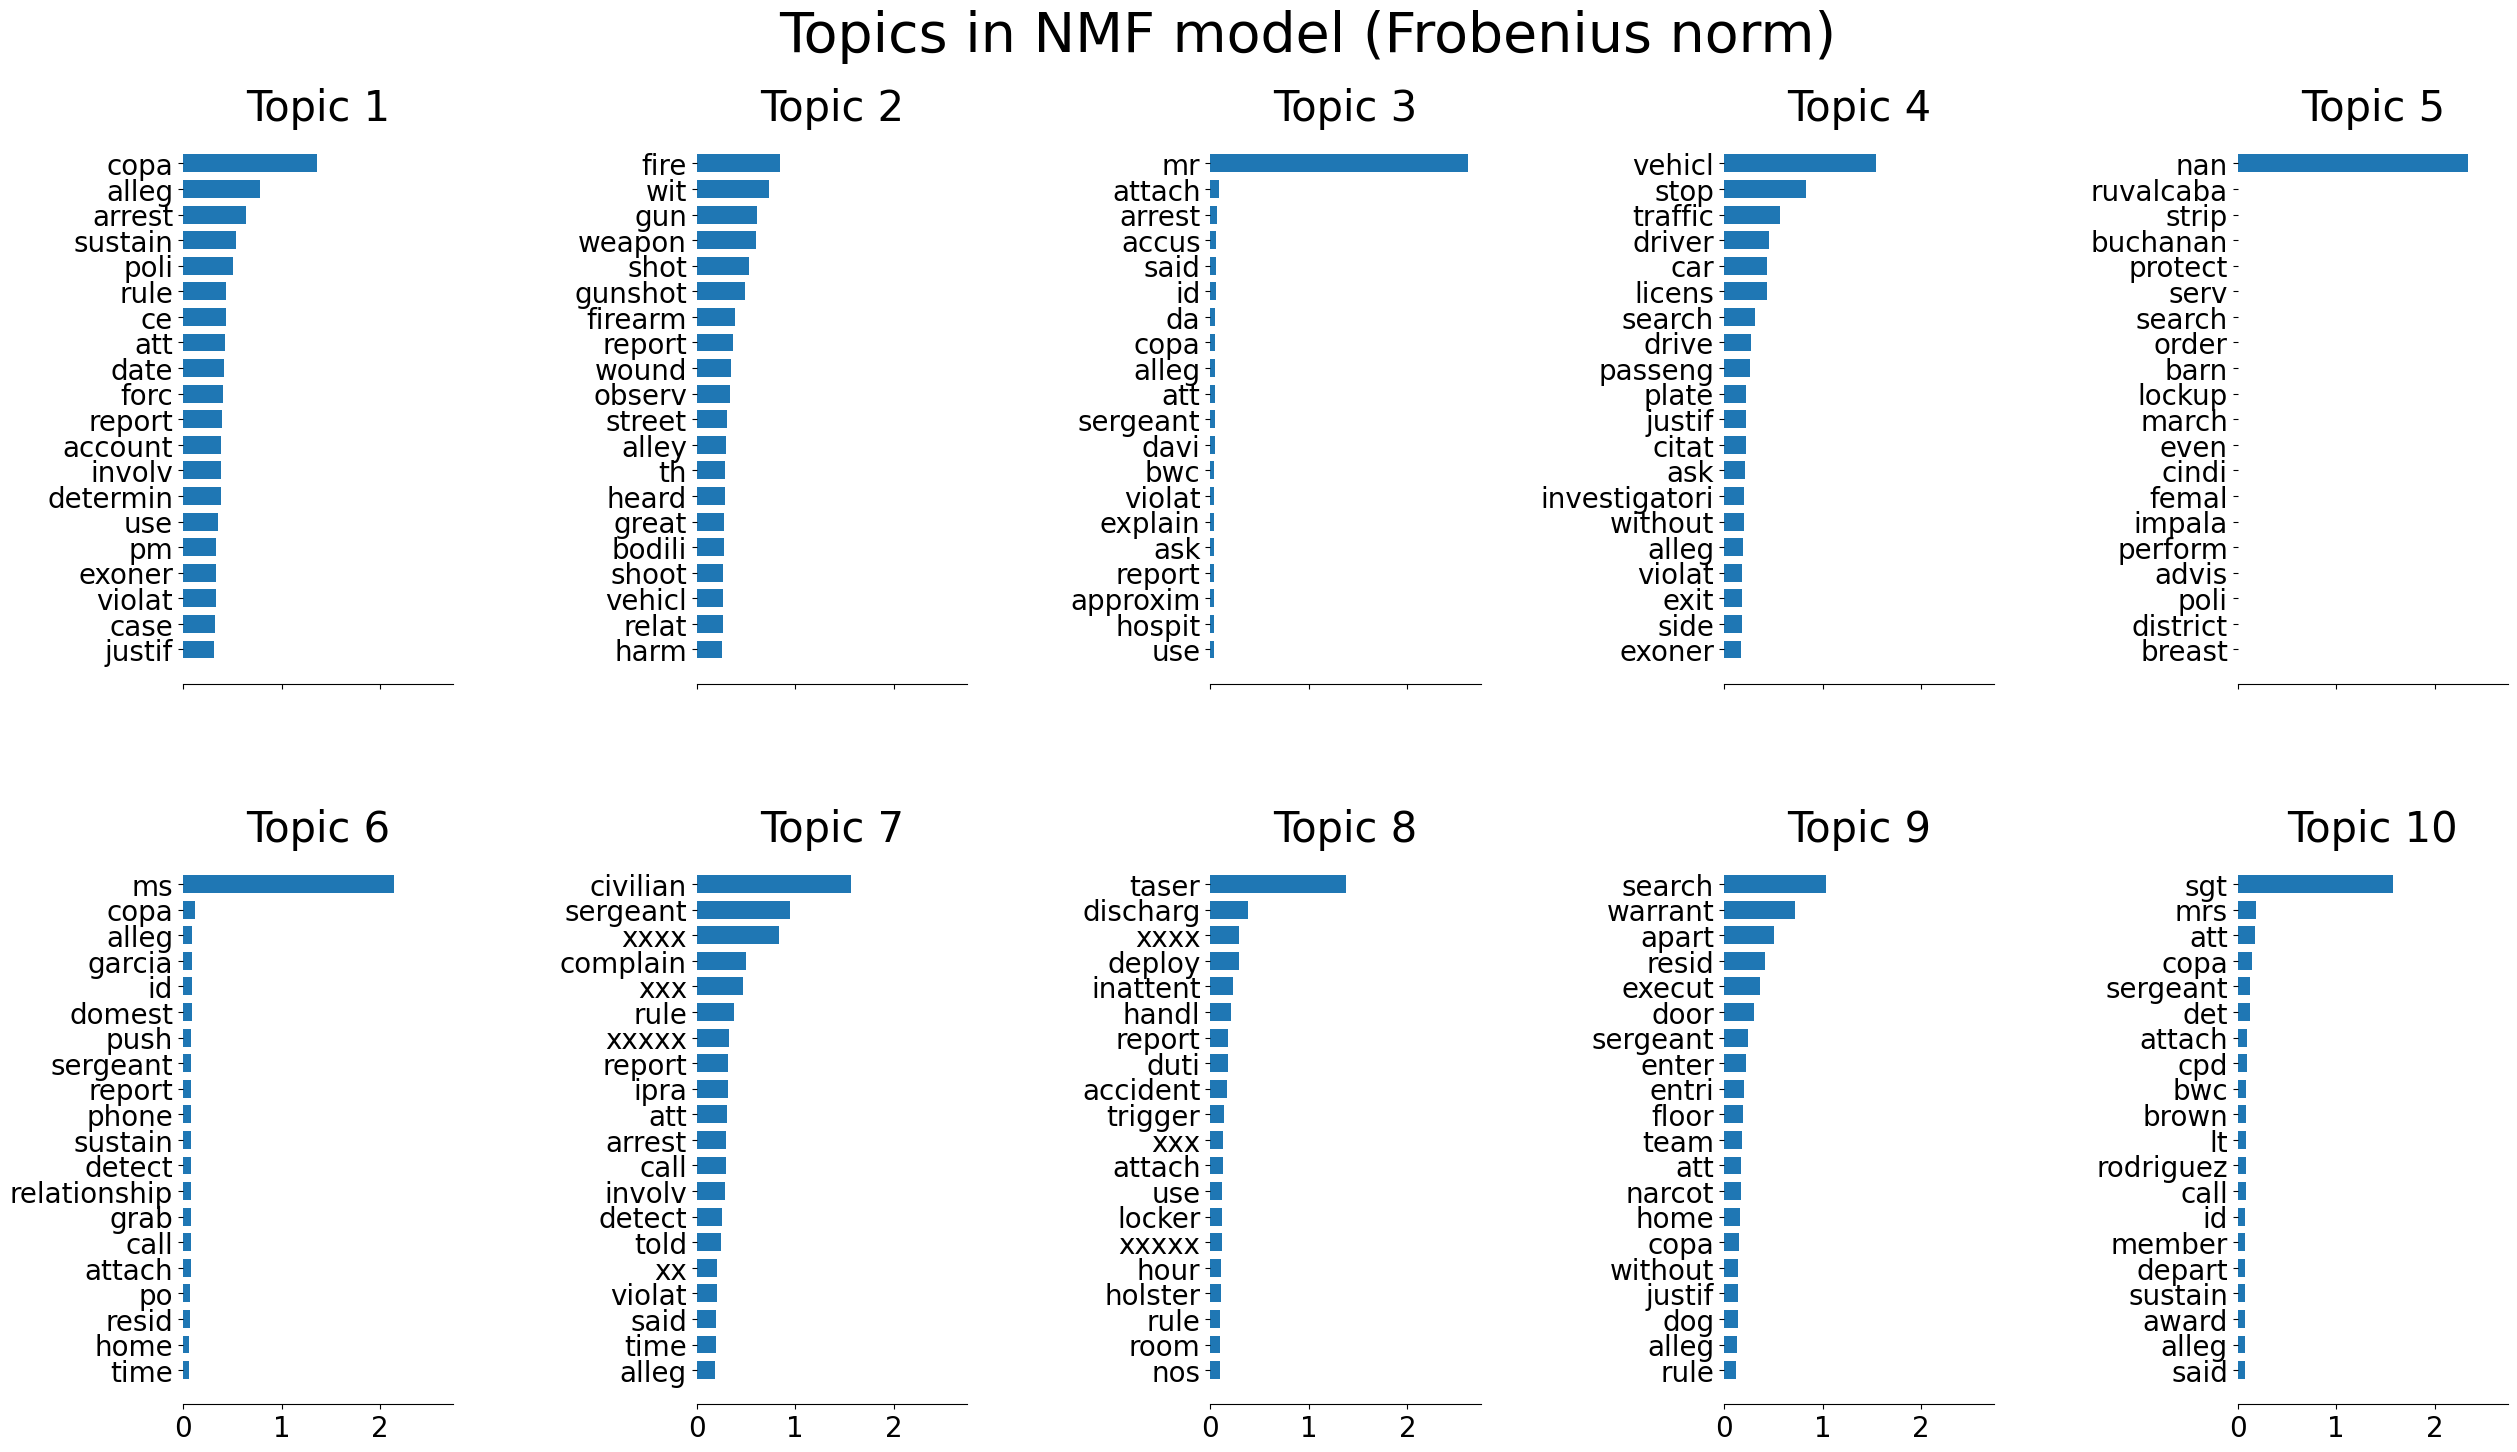

In [21]:
from time import time 

t0 = time()
nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvd", #better for sparseness, sklearn documentation says. Tunable hyperparameter
    beta_loss="frobenius",
    #having any regularization with these alpha_ parameters RUINS it - 
    # just makes most topics a list of words starting with 'fo'
    #alpha_W=0.00005, 
    #alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
#TODO: autosave plot output to file with timestamped title for easy comparison and record-keeping
plot_top_words(nmf, tfidf_feature_names, "Topics in NMF model (Frobenius norm)", n_top_words=20)

#### Kullback-Liebler divergence
(a "generalization of squared distance" between one probability distribution and another https://en.wikipedia.org/wiki/Kullback–Leibler_divergence)

done in 16.592s.


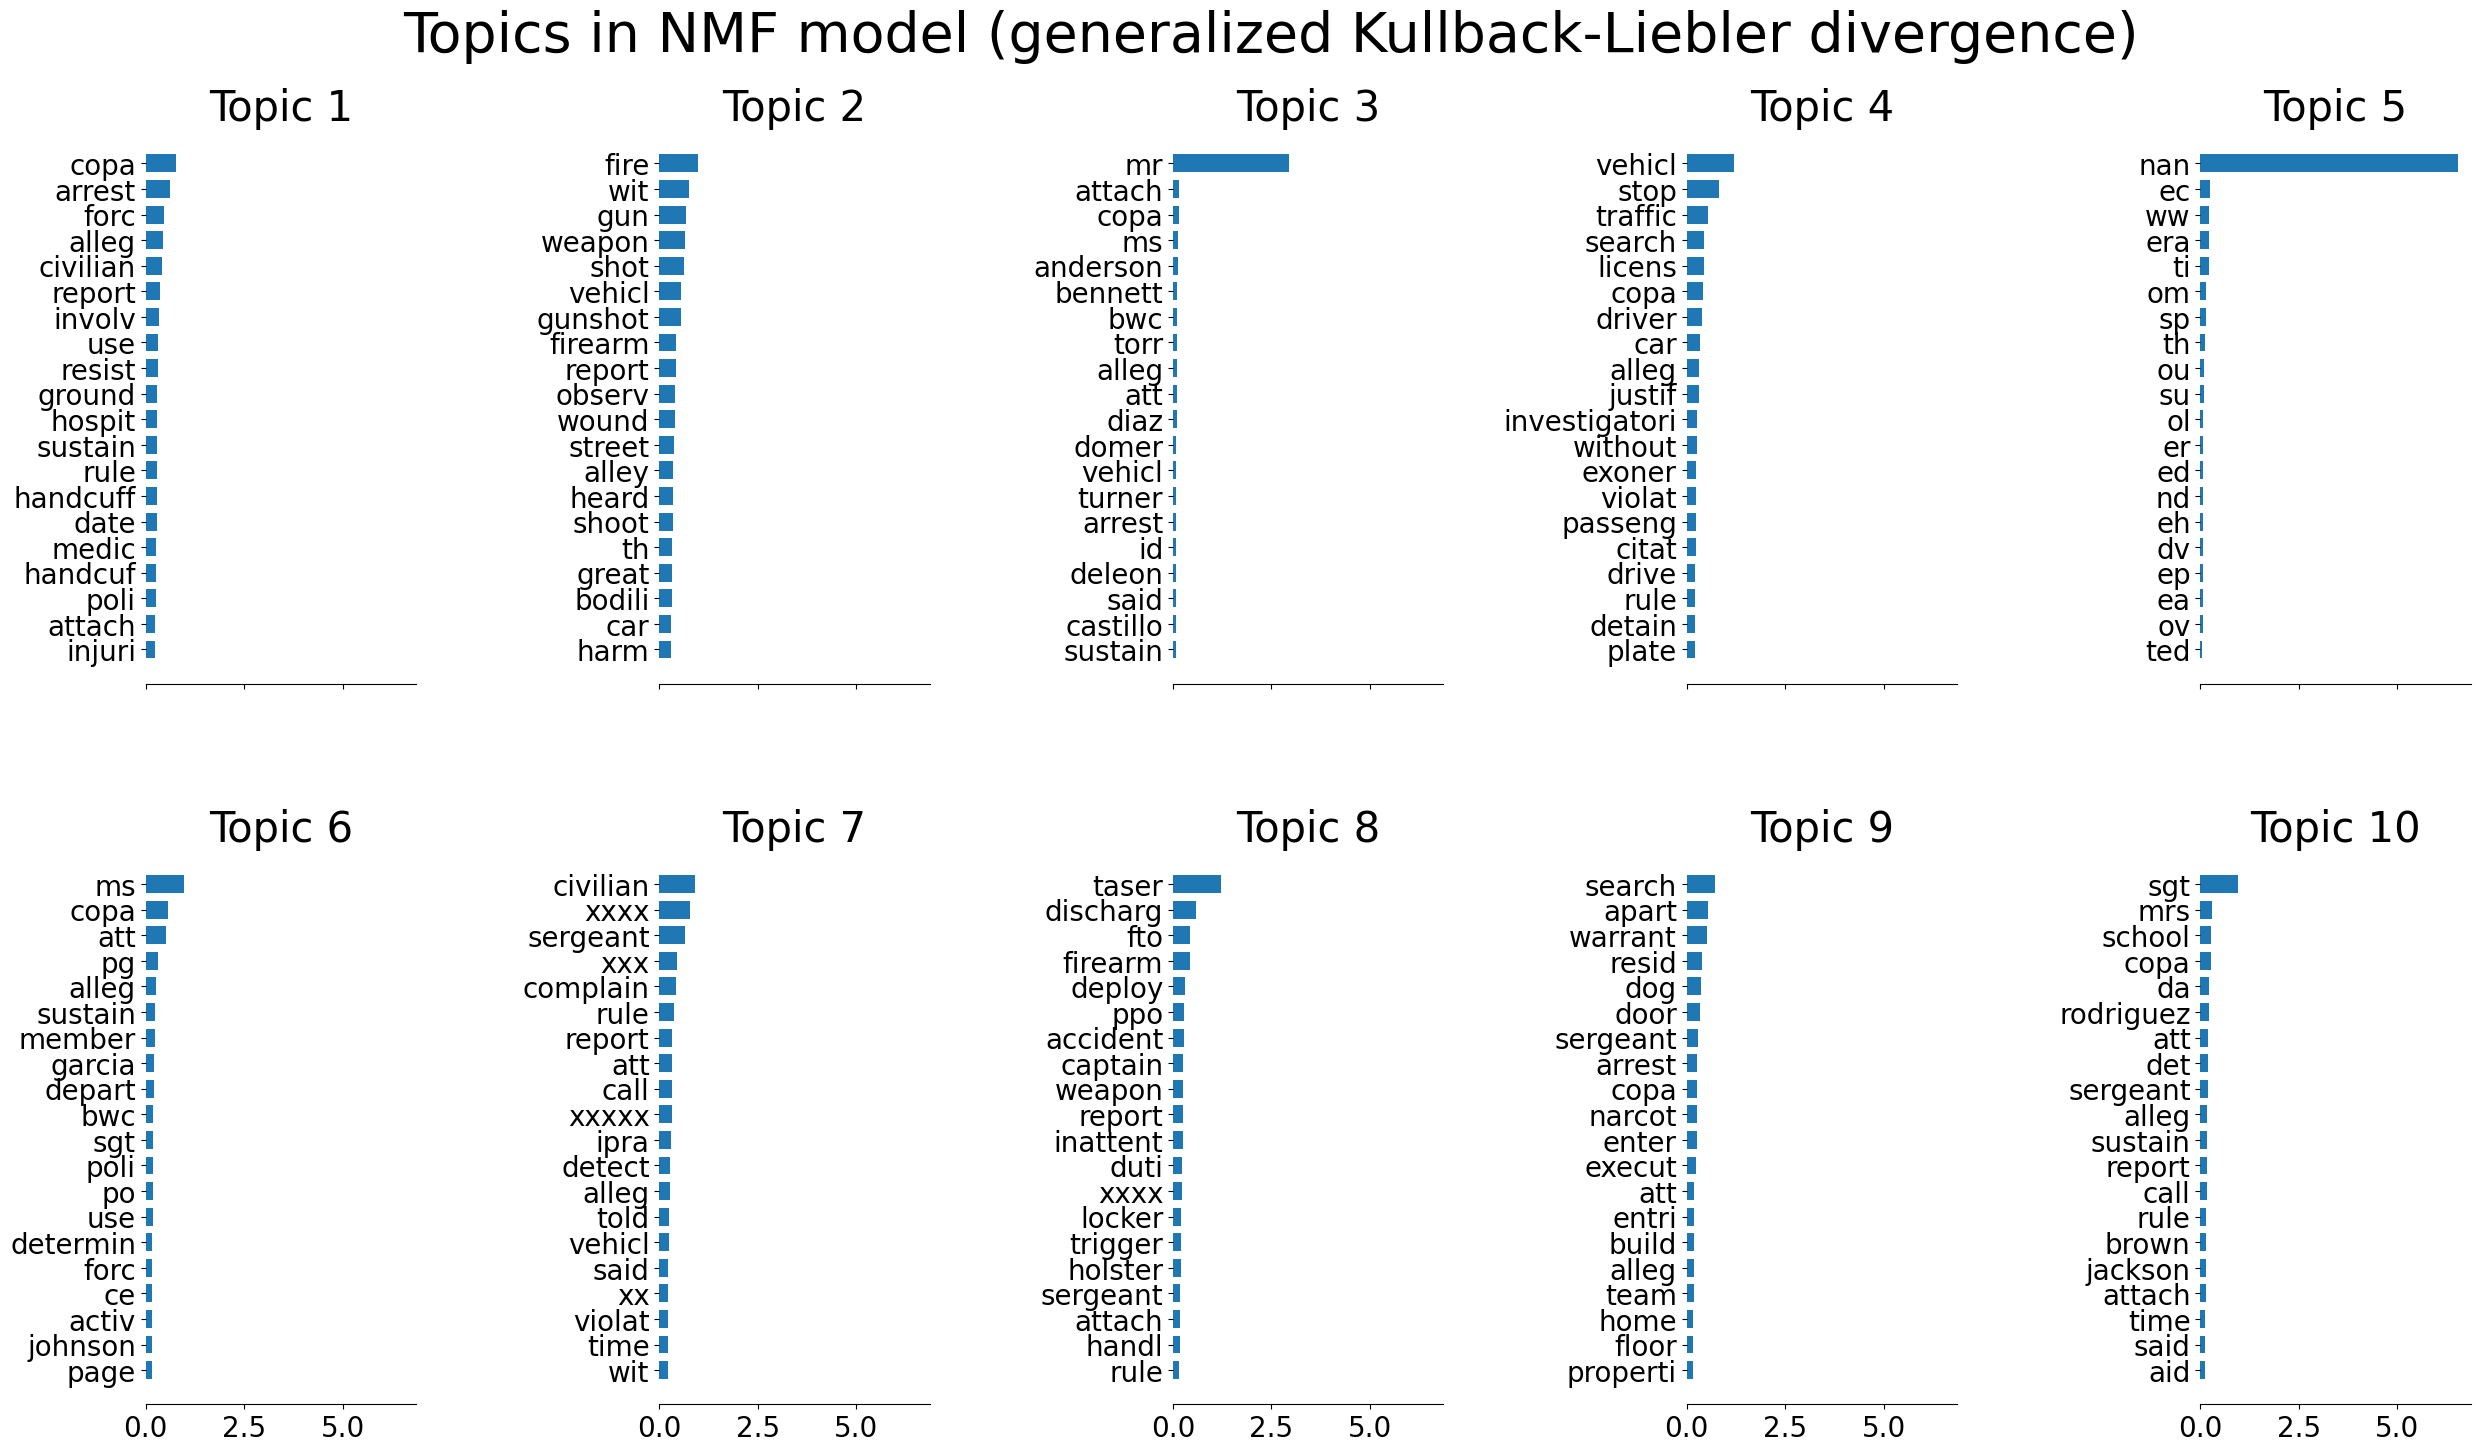

In [24]:
t0 = time()
nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvda", #mu solver should use nndsvdva, not nndsvd
    beta_loss="kullback-leibler",
    solver="mu",
    #alpha_W=0.00005, 
    #alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
#TODO: incorporate more hyperparameters into plot title
#TODO: autosave plot output to file with timestamped title for easy comparison and record-keeping
plot_top_words(nmf, tfidf_feature_names, "Topics in NMF model (generalized Kullback-Liebler divergence)", n_top_words=20)

Initial observations:
- These methods (`nan`, `mr`, and `vehicl` excepted) seem to produce topics with a more sensibly plottable bound of values. More sensible stopword list construction is definitely a must
- Like LDA above, sensible topics do form (Topic 2 of initial run is especially legible - `fire`, `gun`, `weapon`, `shot`, etc...)
- Like LDA above, nonsense words (`xxx` strings, 2-letter words) and individuals' names really confound results; this implementation seems to be confused by `nan`
- Frobenius is much faster to train than Kullback-Liebler - like MUCH faster (~1second)

### K-Means Clustering / Latent Semantic Analysis (LSA) proof of concept

Indebted to: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [39]:
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict
from time import time
from sklearn import metrics

#there is no "true_k" since the data don't have labels. n_clusters must be tuned
#massive variability based on random state initiation.

for seed in range(5):
    kmeans = KMeans(
        n_clusters=6,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()

Number of elements assigned to each cluster: [1029  196   65  295   30  533]
Number of elements assigned to each cluster: [  30  548 1018  295  191   66]
Number of elements assigned to each cluster: [  22  222  301 1022  380  201]
Number of elements assigned to each cluster: [  30  193 1138  302  478    7]
Number of elements assigned to each cluster: [114 293 434 187 705 415]



As can be seen above, the number of documents in each cluster varies wildly (if you check the top words in each cluster, those vary tremendously between randomized runs too). This is because k-means is immensely sensitive to initialization of the first cluster mean before the first iteration, and is subject to a "Curse of Dimensionality" whereby distance metrics become very large as the number of dimensions increases.

Do truncated SVD for dimensionality reduction ("latent semantic analysis"), making k-means results more stable and less prone to Curse of Dimensionality

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#n_components is tunable here too! What should we tune to?
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 1.732 s
Explained variance of the SVD step: 36.9%


In [55]:
# Without LSA: still pretty unstable for low n_clusters and n_init!

NUM_CLUSTERS = 10

for seed in range(5):
    kmeans = KMeans(
        n_clusters=NUM_CLUSTERS,
        max_iter=100,
        n_init=10,
        random_state=seed,
    ).fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()

original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(NUM_CLUSTERS):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
    print()

Number of elements assigned to each cluster: [ 71 318 405 122  58 141 196  66  30 741]
Number of elements assigned to each cluster: [351 196  69 308 340 358  64  73 110 279]
Number of elements assigned to each cluster: [313 334 339  30 109  69 363  92 197 302]
Number of elements assigned to each cluster: [351 307 198 417 342 311  70  68  30  54]
Number of elements assigned to each cluster: [ 30 321 623 345  69 119 223 131  89 198]

Cluster 0: nan ruvalcaba buchanan strip protect serv barn order march even femal cindi lockup impala advis lead ozmina date breast ran 
Cluster 1: civilian sergeant xxxx rule complain report att copa arrest alleg xxx vehicl ipra call violat xxxxx wit sustain time told 
Cluster 2: copa alleg att sustain arrest report rule search attach forc use involv date depart poli pm violat bwc civilian time 
Cluster 3: vehicl stop copa search traffic alleg licens justif driver att car without exoner rule arrest violat attach bwc investigatori sustain 
Cluster 4: ms copa 

In [60]:
#Without LSA

NUM_CLUSTERS = 6

for seed in range(5):
    kmeans = KMeans(
        n_clusters=NUM_CLUSTERS,
        max_iter=100,
        n_init=20,
        random_state=seed,
    ).fit(tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()

original_space_centroids=kmeans.cluster_centers_ #figure out how to fix this when LSA not on
#original_space_centroids = tfidf[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(NUM_CLUSTERS):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
    print()

Number of elements assigned to each cluster: [1029  196   65  295   30  533]
Number of elements assigned to each cluster: [  30  548 1018  295  191   66]
Number of elements assigned to each cluster: [191  30 848 348 436 295]
Number of elements assigned to each cluster: [293 408 195 862  30 360]
Number of elements assigned to each cluster: [295 190 397 842  30 394]

Cluster 0: fire wit gun weapon shot vehicl gunshot report wound firearm observ street heard th relat car alley great bodili ipra 
Cluster 1: mr copa vehicl alleg ms search arrest attach att report stop sustain rule sgt sergeant violat bwc id car date 
Cluster 2: vehicl stop copa search traffic alleg licens justif att car driver rule without violat exoner arrest report sustain attach investigatori 
Cluster 3: copa sgt ms att alleg report sustain attach rule taser sergeant use arrest forc search depart vehicl discharg firearm time 
Cluster 4: nan àvis founder four fourdoor fourinch fourman fourt fourteen fourteenth fourteenyea

Initial observations:

- You do see the "guns" cluster and the "vehicles/traffic" cluster show up again
- If we do this, I'll want to make a prettier data viz where length of bar for each word is something like "inverse distance to centroid of cluster" scaled in some sane manner
- Consider doing Gaussian EM clustering instead of k-means to better account for clusters of differing size: https://scikit-learn.org/stable/modules/mixture.html 
    - (see also: Rebecca Willett, Mathematical Foundations of Machine Learning, Lecture 18 (2021), https://uchicago.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=021bf34c-60b3-4dd1-a57f-adf2014a2016)
    - http://www.cs.columbia.edu/~smaskey/CS6998-0412/slides/week3_statnlp_web.pdf
    - Unless LDA is already doing this under the hood? Investigate math further
- Without LSA on, I once again get that cluster of words starting with "fou-" (`founder` `four` `fourdoor` `fourinch` `fourman` `fourt` `fourteen`....) Why is this happening across models? Is there an unusual density of words with those starting letters? Consider searching the tf-idf for word-initial trigrams and mapping them to see if there's something odd here